AR terms:   0%|                                                                                  | 0/5 [00:00<?, ?it/s]C:\Users\code10000\AppData\Local\anaconda3\envs\torch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\code10000\AppData\Local\anaconda3\envs\torch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\code10000\AppData\Local\anaconda3\envs\torch\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\code10000\AppData\Local\anaconda3\envs\torch\lib\site-packages\statsmodels\tsa\statespace\sa

Best order: (2, 1, 1), Best MSE: 18165.19208668053


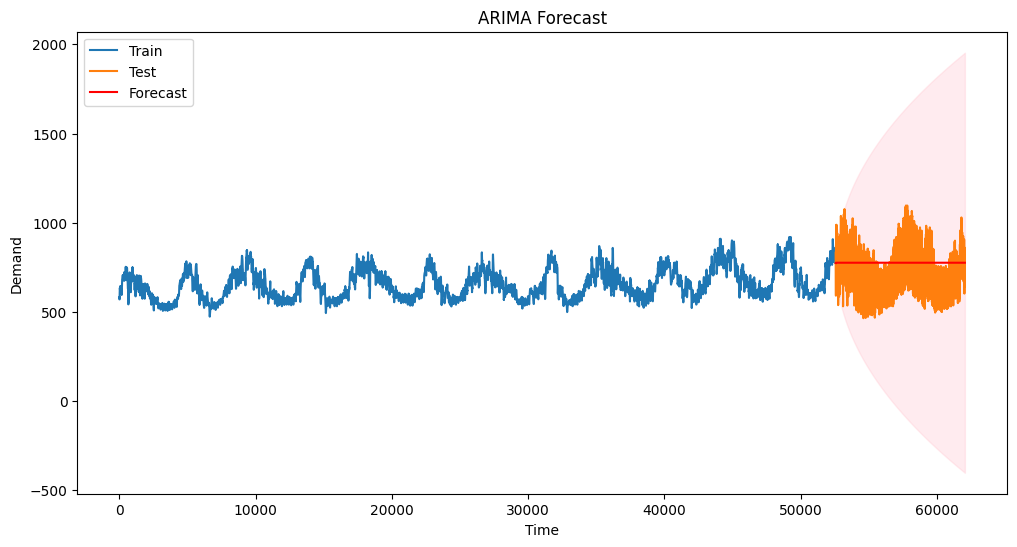

Mean Squared Error: 18165.19208668053
ARIMA forecast results saved to arima_forecast_results.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# 데이터 로드 및 전처리
file_path = './data/data.csv'  # 데이터 파일 경로
data = pd.read_csv(file_path)  # CSV 파일 로드

# 학습 및 테스트 데이터 분리
train_years = [17, 18, 19, 20, 21, 22]  # 학습에 사용할 연도
test_year = 23  # 테스트에 사용할 연도

train_data = data[data['year'].isin(train_years)]  # 학습 데이터
test_data = data[data['year'] == test_year]  # 테스트 데이터

# 계절성 분해
train_series = train_data['수요량']
decomposition = seasonal_decompose(train_series, model='multiplicative', period=24)
train_series = decomposition.trend.dropna()  # 추세 요소만 사용

# 데이터 스케일링
scaler = StandardScaler()
train_series_scaled = scaler.fit_transform(train_series.values.reshape(-1, 1)).flatten()
test_series = test_data['수요량']
test_series_scaled = scaler.transform(test_series.values.reshape(-1, 1)).flatten()

# Grid Search를 통한 최적의 파라미터 탐색
best_order = None
best_mse = float("inf")

for p in tqdm(range(1, 6), desc="AR terms"):
    for d in range(1, 3):
        for q in range(1, 6):
            try:
                model = ARIMA(train_series_scaled, order=(p, d, q))
                model_fit = model.fit()
                forecast_result = model_fit.get_forecast(steps=len(test_series))
                forecast = scaler.inverse_transform(forecast_result.predicted_mean.reshape(-1, 1)).flatten()
                mse = mean_squared_error(test_series, forecast)
                if mse < best_mse:
                    best_mse = mse
                    best_order = (p, d, q)
            except Exception as e:
                continue

print(f'Best order: {best_order}, Best MSE: {best_mse}')

# 최적의 파라미터로 모델 학습 및 예측
model = ARIMA(train_series_scaled, order=best_order)
model_fit = model.fit()
forecast_result = model_fit.get_forecast(steps=len(test_series))
forecast = scaler.inverse_transform(forecast_result.predicted_mean.reshape(-1, 1)).flatten()
conf_int = scaler.inverse_transform(forecast_result.conf_int())

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_series.index, scaler.inverse_transform(train_series_scaled.reshape(-1, 1)).flatten(), label='Train')
plt.plot(test_series.index, test_series, label='Test')
plt.plot(test_series.index, forecast, label='Forecast', color='red')
plt.fill_between(test_series.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

# 성능 평가 (MSE 계산)
mse = mean_squared_error(test_series, forecast)
print(f'Mean Squared Error: {mse}')

# 예측 결과 저장
results = test_data.copy()
results['Forecast'] = forecast
results.to_csv('arima_forecast_results.csv', index=False)
print('ARIMA forecast results saved to arima_forecast_results.csv')
